## Modularity on the Karate Club Graph
This notebook analyzes **community structure** using modularity in NetworkX.

## What we need to do::
- Implement recursive spectral modularity partitioning to detect multiple communities in the Karate Club graph  
- Visualize the graph after each split with different colors for communities  
- Compute node metrics (degree centrality, betweenness centrality, closeness centrality, clustering)  
- Plot how these metrics evolve across iterations  
- Write a short discussion about which nodes remain central and how community structure influences metrics

## We start by importing all the necessary libraries like Numpy, NetworkX and matplotlib.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain


Now we will see how this karate club graph looks like which we will just take form the networkx lib.

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


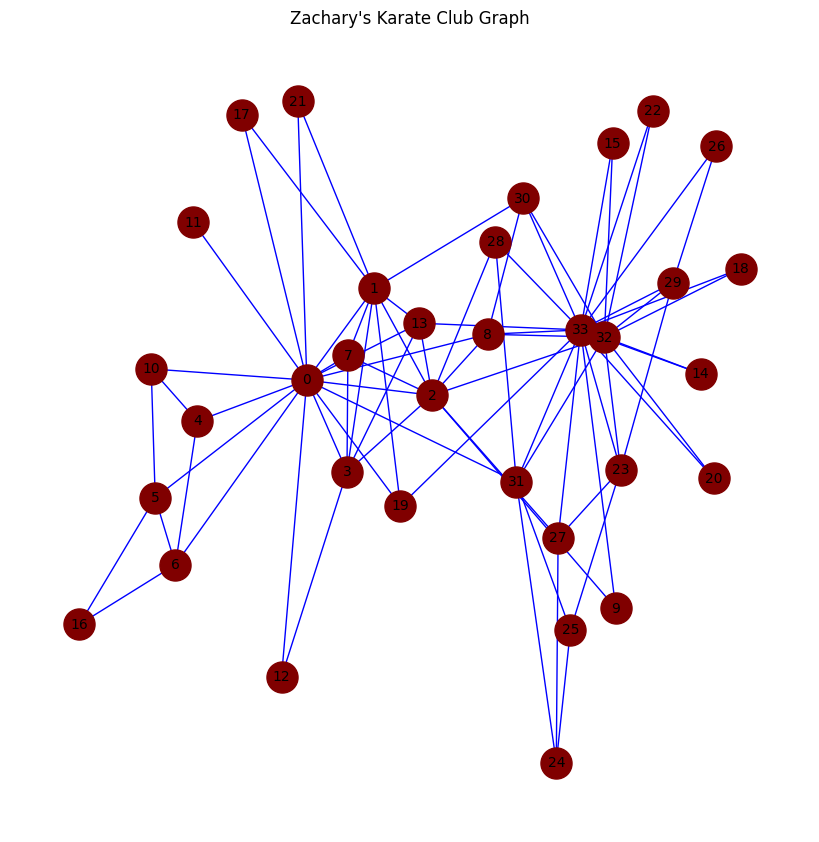

In [2]:
G= nx.karate_club_graph()
print(G)
pos= nx.spring_layout(G,seed=7)
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color="maroon", edge_color="blue", node_size=500, font_size=10)
plt.title("Zachary's Karate Club Graph")
plt.show()


Now we will define the adjacency matrix, A and required things in order to get **modularity matrix(B)**:
$$
\mathbf{B} = \mathbf{A} - \frac{\mathbf{k} \mathbf{k}^\top}{2m},
$$

    where, A = adjacency matrix with n rows and n coulumn.
           k = degree matrix with n rows and 1 column.
           m = no. of edges.

In [3]:
A=nx.to_numpy_array(G)
node_list= list(G.nodes())
n=len(node_list)
k = np.array([G.degree(node) for node in node_list]).reshape(n,1)
# list comprehension to ensure order of nodes is same as in node_list.
m = np.sum(k)/2
print("Adjacency matrix:\n",A)
print("degree matrix:\n",k)
print("Number of Edges: ",m)

Adjacency matrix:
 [[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]
degree matrix:
 [[16]
 [ 9]
 [10]
 [ 6]
 [ 3]
 [ 4]
 [ 4]
 [ 4]
 [ 5]
 [ 2]
 [ 3]
 [ 1]
 [ 2]
 [ 5]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 3]
 [ 2]
 [ 2]
 [ 2]
 [ 5]
 [ 3]
 [ 3]
 [ 2]
 [ 4]
 [ 3]
 [ 4]
 [ 4]
 [ 6]
 [12]
 [17]]
Number of Edges:  78.0


Now we have everything to find our Modularity Matrix,B.

In [4]:
B = A - (np.matmul(k,k.T))/(2*m)
print(B)

[[-1.64102564  3.07692308  3.97435897 ...  1.38461538 -1.23076923
  -1.74358974]
 [ 3.07692308 -0.51923077  5.42307692 ... -0.34615385 -0.69230769
  -0.98076923]
 [ 3.97435897  5.42307692 -0.64102564 ... -0.38461538  1.23076923
  -1.08974359]
 ...
 [ 1.38461538 -0.34615385 -0.38461538 ... -0.23076923  3.53846154
   3.34615385]
 [-1.23076923 -0.69230769  1.23076923 ...  3.53846154 -0.92307692
   3.69230769]
 [-1.74358974 -0.98076923 -1.08974359 ...  3.34615385  3.69230769
  -1.8525641 ]]


Since we got our Modularity Matrix, we can now calculate **Modularity Score, Q** which is given by:

$$
Q = \frac{1}{4m} \mathbf{s}^\top \mathbf{B} \mathbf{s}.
$$
    where, Q is a function of s, a label vector which assigns +1 or -1 to all nodes based on the community they belong to.

Here," $\mathbf{s}^\top \mathbf{B} \mathbf{s}$ " measures how well the vertex partition
induced by s (recall that the elements of s are +1 or −1 and induces a partition over the vertex
set) aligns with positive values in B (i.e., pairs that are more connected than chance).

**Large positive Value of Q --> more within-community edges than expected at random.**

So that the entire problem of community detection (in this simplified two-community case) boils down to a single task:

$$
\textit{Choose the components of } \mathbf{s} \in \{-1, +1\}^n \textit{ so that } 
Q = \frac{1}{4m}\, \mathbf{s}^\top \mathbf{B}\, \mathbf{s} \textit{ is maximized.}
$$

So what we have to do now is to find the Vector **s** that maximizes Q.
But since s ∈ {−1, +1}, maximizing over all {−1, +1}
n vectors means checking 2n possible assignments which is impossible even for moderate n. So we use a standard trick in optimization: relax the problem.
Therefore we allow $s_i$ to take any real value but constrain $∥s∥_2$ = 1(which just represent the norm of s.)
Then the problem becomes:
$$
\max_{\|s\|_2 = 1} \; s^\top B s .
$$

A classic result from linear algebra says: **the maximizer of the above maximization problem is the eigenvector of B corresponding to the largest eigenvalue, called the leading eigenvector.**

Now we will calculate EigenValues and EigenVectors of Modularity Matrix from there we will get our Leading EigenValue which is nothing but the largest eigenvalue of Modularity Matrix and it corresponds to Leading EigenVector which is the most useful thing in community detection in Graph.

This is called **Spectral bipartition algorithm.**

In the relaxation, $u_1$ gives us a “soft assignment” of nodes: nodeswith positive entries are pushed toward one side of the split and nodes with negative entries are pushed toward the other. Intuitively:

• If $(u_1)_i$ is strongly positive, node i “wants” to be in community 1.

• If $(u_1)_i$ is strongly negative, node i “wants” to be in community 2.

• If $(u_1)_i$ is close to zero, node i is not strongly tied to either side.

Since we need a hard partition, we simply assign:
$$
s_i =
\begin{cases}
+1 & \text{if } ( \mathbf{u}_1 )_i > 0, \\
-1 & \text{otherwise}.
\end{cases}
$$

This gives us a discrete $\mathbf{s} \in \{-1, +1\}^n ,$, i.e., a proper bipartition of the graph.

In [5]:
def spectral_bisection(G, nodes):
    # Work on a subgraph with a fixed node order
    subG = G.subgraph(nodes)
    ordered = list(subG.nodes())
    A = nx.to_numpy_array(subG, nodelist=ordered, dtype=float)

    # Degrees and m computed on the *subgraph* (OK for this assignment; you can switch to global if you prefer)
    k = A.sum(axis=1)
    m = k.sum() / 2.0
    if m == 0:
        # No edges; cannot split
        return 0.0, ordered, []

    B = A - np.outer(k, k) / (2.0 * m)

    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argmax(eigvals)
    leading_val = float(eigvals[idx])
    leading_vec = eigvecs[:, idx]
    s = np.sign(leading_vec)
    s[s == 0] = 1  # avoid empty side

    group1 = [ordered[i] for i in range(len(ordered)) if s[i] > 0]
    group2 = [ordered[i] for i in range(len(ordered)) if s[i] <= 0]

    return leading_val, group1, group2

nodes=list(G.nodes())
leading_val, group1, group2=spectral_bisection(G, nodes)


			   First Spectral Bipartition of the Karate Club Graph:

Using the modularity matrix 𝐵 and the leading eigenvector of 𝐵, we perform a spectral bisection
of the full Karate Club graph.

Nodes are divided into two communities based on the sign of the eigenvector entries (+ vs −).
The two clusters detected are visualized below with different color.

And this looks exactly how our Karate Club would've been split into two communities.
One following the club president, the other following Mr. Hi.



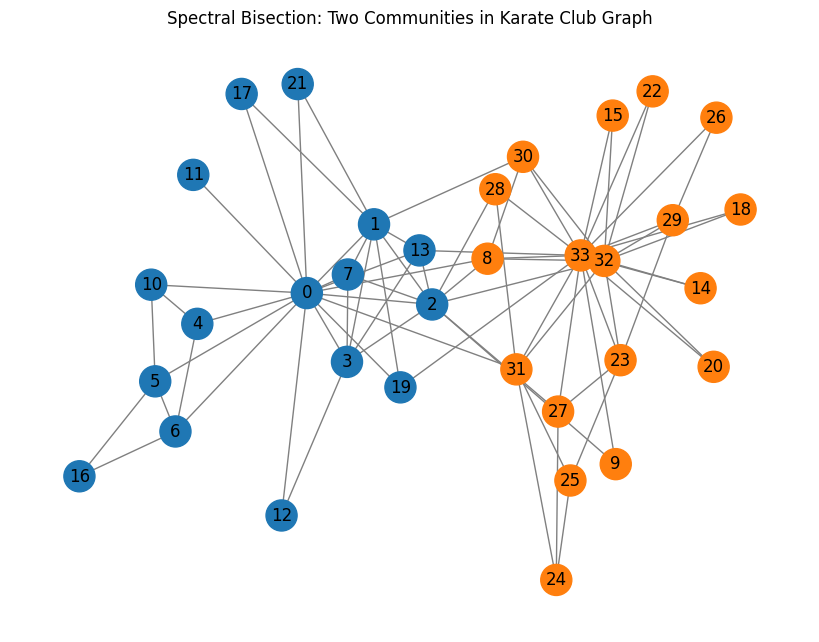

Community 1: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Community 2: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [6]:
print("\t\t\t   First Spectral Bipartition of the Karate Club Graph:\n")
print("Using the modularity matrix 𝐵 and the leading eigenvector of 𝐵, we perform a spectral bisection\nof the full Karate Club graph.\n")
print("Nodes are divided into two communities based on the sign of the eigenvector entries (+ vs −).\nThe two clusters detected are visualized below with different color.\n")
print("And this looks exactly how our Karate Club would've been split into two communities.\nOne following the club president, the other following Mr. Hi.\n")



colors = []
for n in G.nodes():
    if n in group1:
        colors.append("tab:blue")
    else:
        colors.append("tab:orange")

plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=True, node_color=colors, edge_color="gray", node_size=500)
plt.title("Spectral Bisection: Two Communities in Karate Club Graph")
plt.show()

print("Community 1:", group1)
print("Community 2:", group2)


Now we move on to do **Iterative Algorithm to Detect All Communities** which will be done by:
##                                  Recursive Spectral Modularity Partitioning



So what we do in Recursive Spectral Modularity is nothing but we start with full vertex Set V and then try to find Modularity matrix B and try to find 2 community by Spectral Bipartition Algorithm and if we finds 2 different communities (which is detemined by whether the largest eigenvalue is >=0 or not.), then we try to find more communities in those two communities itself and therefore we apply **Recursive Spectral Modularity Partition Algorithm** which takes help of EigenValue test.

## EigenValue Test:

Compute the leading eigenpair $(\lambda^{(C)}_{1},\, \mathbf{u}^{(C)}_{1})$ of $\mathbf{B}^{(C)}$ ($\mathbf{B}^{(C)}$ is Modularity for induced Subgraph.):
- If $\lambda^{(C)}_{1} > 0$, then splitting $C$ by the signs of the entries of $\mathbf{u}^{(C)}_{1}$ increases modularity.
- If $\lambda^{(C)}_{1} \le 0$, then no further split improves modularity and $C$ should remain as a single community.

## Recursive bisection (multi-community detection):
We extend the two-way spectral split into a multi-community detection algorithm by applying the procedure recursively:

1. Start with the full vertex set $V$.
2. If $V$ can be split (i.e., its largest eigenvalue $> 0$), divide it into two groups $\mathbf{C}^{+}$ and $\mathbf{C}^{-}$ by the sign of $u_1$
3. Recurse on $\mathbf{C}^{+}$ and $\mathbf{C}^{-}$ separately.
4. Stop when all groups have nonpositive leading eigenvalues.

At the end, we obtain a partition of $V$ into multiple communities, each of which is **stable** in the sense that no further modularity-improving split exists.
And hence we obtain a set of communities {$C_1, C_2, . . . , C_r$}.

In [7]:
def plot_communities_step(G, communities, pos, iteration, Q_val=None, save=False):
    # Assign default gray color for all nodes
    node_colors = {n: "#D3D3D3" for n in G.nodes()}

    # Assign distinct colors per community
    cmap = plt.cm.get_cmap("tab20", max(2, len(communities)))
    for i, comm in enumerate(communities):
        color = cmap(i)
        for n in comm:
            node_colors[n] = color

    plt.figure(figsize=(8, 6))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=[node_colors[n] for n in G.nodes()],
        edge_color="gray",
        node_size=500
    )

    # Title with Q displayed inline
    if Q_val is not None:
        plt.title(f"Recursive Spectral Modularity — Iteration {iteration}   (Q = {Q_val:.4f})")
    else:
        plt.title(f"Recursive Spectral Modularity — Iteration {iteration}")

    if save:
        plt.savefig(f"iteration_{iteration}.png", dpi=300, bbox_inches="tight")
    plt.show()


In [8]:
def recursive_partition(G, min_size=3):
    """
    Returns a flat list of final communities (lists of node IDs).
    Stops splitting when leading eigenvalue <= 0 or size < min_size.
    """
    communities = []
    stack = [list(G.nodes())]

    while stack:
        nodes = stack.pop()
        if len(nodes) < min_size:
            communities.append(nodes)
            continue

        leading_val, g1, g2 = spectral_bisection(G, nodes)

        # If cannot improve modularity or split is degenerate, accept as final
        if leading_val <= 0 or len(g1) == 0 or len(g2) == 0:
            communities.append(nodes)
        else:
            stack.append(g1)
            stack.append(g2)

    return communities


Iteration 1 | Communities: 2 | Modularity Q = 2.1792


/tmp/ipykernel_8005/1430049135.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(2, len(communities)))


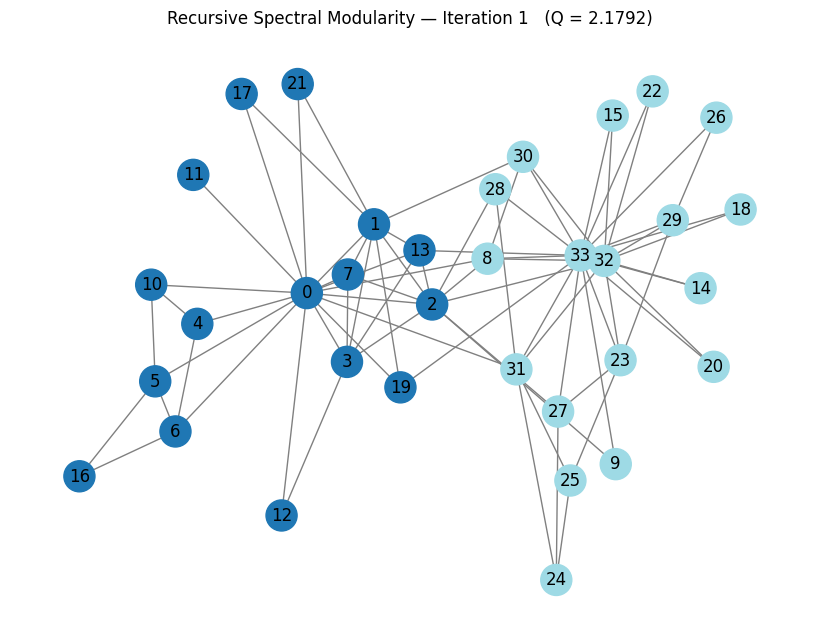

Iteration 2 | Communities: 4 | Modularity Q = 1.7652


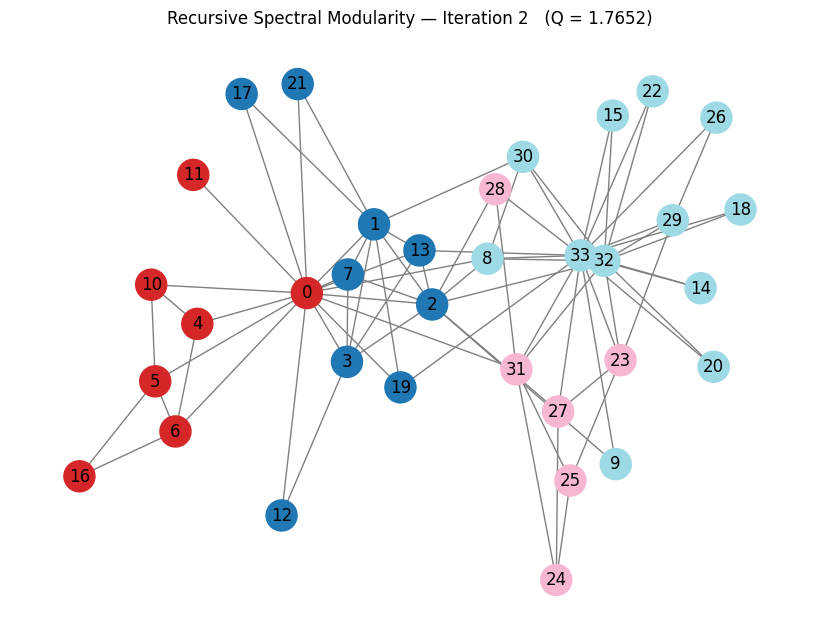

Iteration 3 | Communities: 8 | Modularity Q = 1.3308


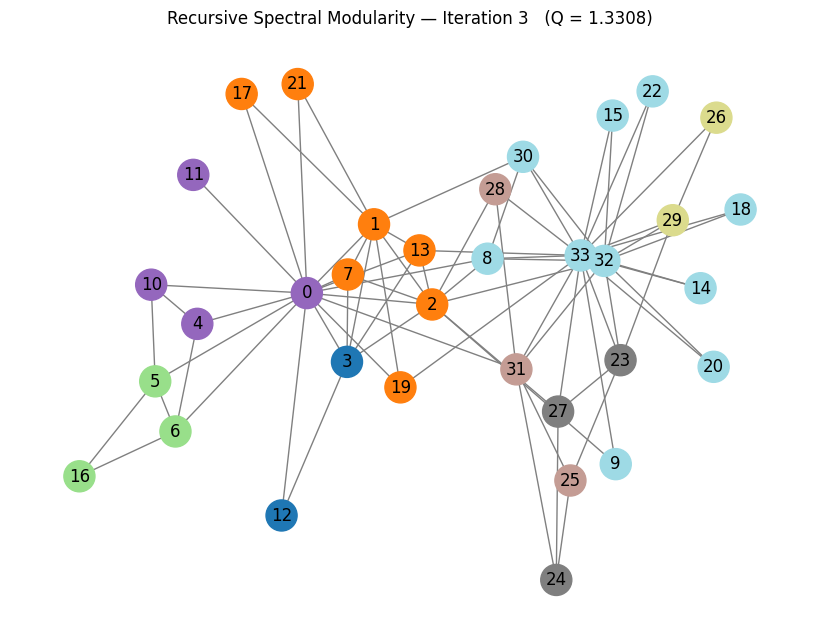

Iteration 4 | Communities: 10 | Modularity Q = 0.8623


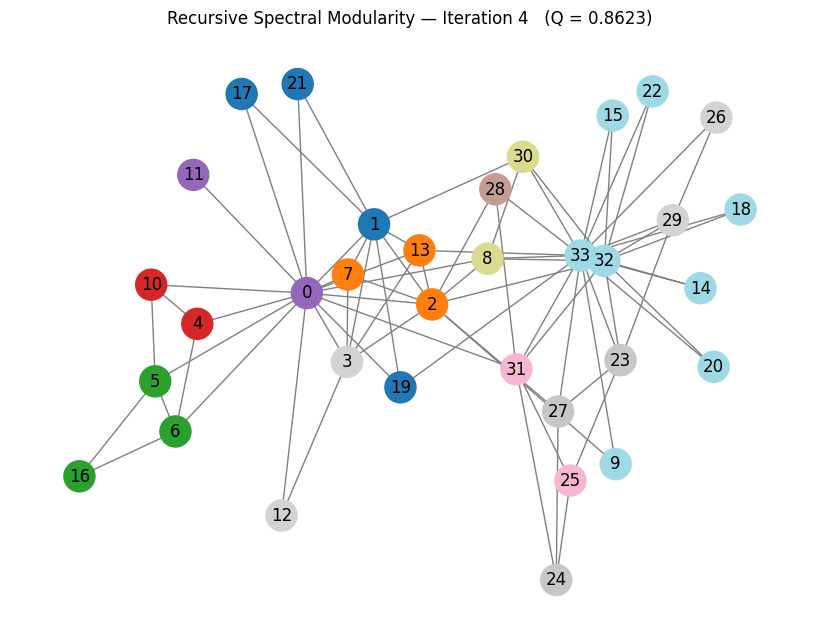

Iteration 5 | Communities: 8 | Modularity Q = 0.4758


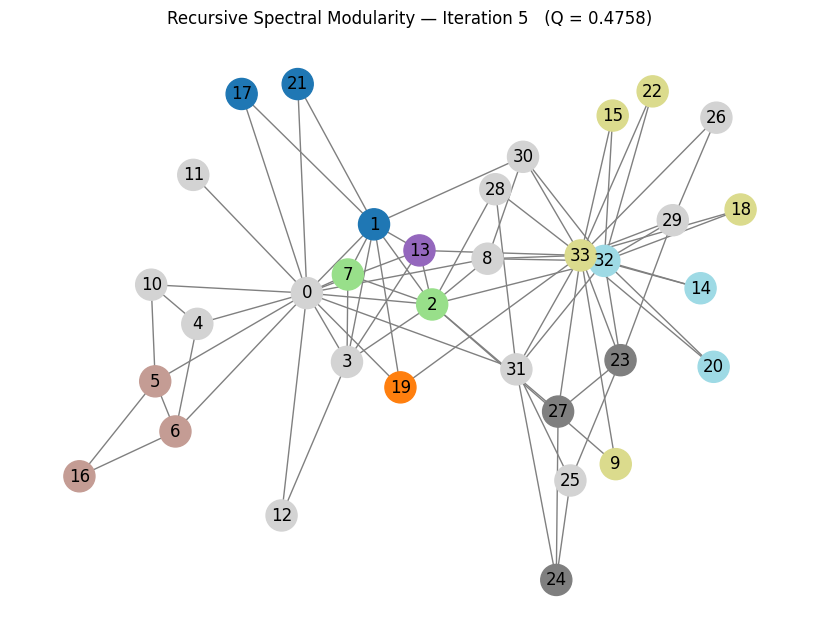

Iteration 6 | Communities: 5 | Modularity Q = 0.4340


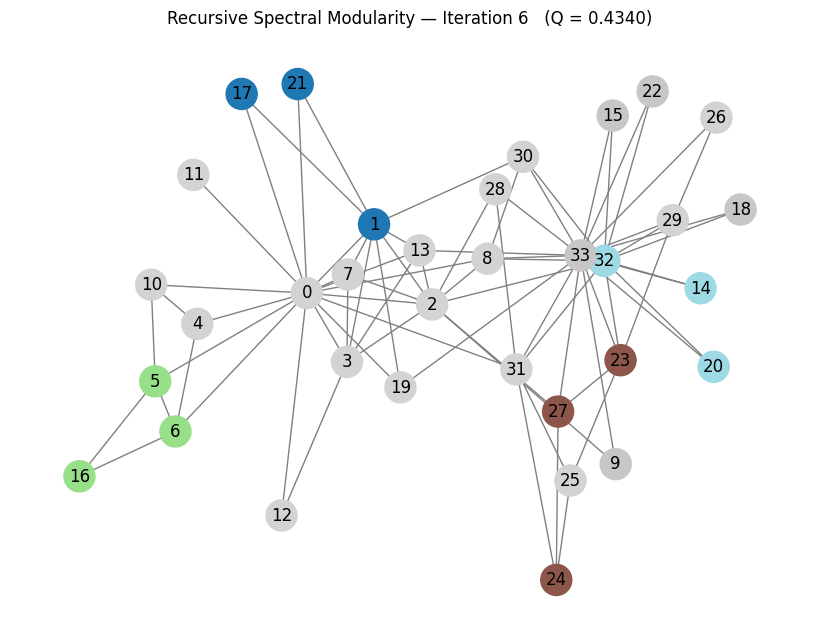

In [9]:
def modularity_of_partition(G, communities):
    """Compute the global modularity Q of the full graph given a partition."""
    B = A - (np.matmul(k, k.T)) / (2 * m)
    Q = 0
    for comm in communities:
        idx = [list(G.nodes()).index(n) for n in comm]
        sub_B = B[np.ix_(idx, idx)]
        Q += sub_B.sum()
    return Q / (2 * m)


iteration = 1
remaining = [list(G.nodes())]

while remaining:
    all_communities = []
    
    # Split one level deeper
    for nodes in remaining:
        leading_val, g1, g2 = spectral_bisection(G, nodes)
        if leading_val <= 0 or len(g1) == 0 or len(g2) == 0 or len(nodes) < 3:
            all_communities.append(nodes)
        else:
            all_communities.extend([g1, g2])

    # Compute modularity for this partition
    Q_val = modularity_of_partition(G, all_communities)
    print(f"Iteration {iteration} | Communities: {len(all_communities)} | Modularity Q = {Q_val:.4f}")
    
    # Plot and show Q value in title
    plot_communities_step(G, all_communities, pos, iteration, Q_val=Q_val, save=False)

    next_remaining = [c for c in all_communities if len(c) >= 3]

    if next_remaining == remaining or len(next_remaining) == 0:
        break

    remaining = next_remaining
    iteration += 1
